# Notebook custom model

## Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import logging
import tensorflow as tf

# Désactiver une partie des messages d'erreur TF
tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [3]:
import joblib

# Réimportation des données
progression_data1 = joblib.load('progression_data1.joblib')
data = progression_data1['data']
data_test = progression_data1['data_test']
list_labels = progression_data1['list_labels']
categ = progression_data1['categ']
label_list = progression_data1['label_list']
X_test = progression_data1['X_test']
y_test = progression_data1['y_test']
X_train = progression_data1['X_train']
X_val = progression_data1['X_val']
y_train = progression_data1['y_train']
y_val = progression_data1['y_val']



# Etape 2 : création et d’entraînement de modèles personnel
2 approches sont présentées :
* Une version simple (v0)
* Une version améliorée (v1)

# Model custom v0

In [4]:
def create_custom_v0_model_fct() :
    import keras
    # Model
    model = keras.models.Sequential([
        # Couche convolutive avec 64 filtres de taille 11x11 et un pas de 4x4
        keras.layers.Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        # Couche de max pooling pour réduire la dimensionnalité
        keras.layers.MaxPool2D(pool_size=(2,2)),
        # Couche convolutive avec 128 filtres de taille 5x5, pas de stride et même rembourrage
        keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        # Couche de pooling
        keras.layers.MaxPool2D(pool_size=(3,3)),
        # Couche convolutive avec 128 filtres de taille 3x3, même rembourrage
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        # Couche convolutive avec 128 filtres de taille 1x1, même rembourrage
        keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        # Couche de pooling
        keras.layers.MaxPool2D(pool_size=(2,2)),
        # Aplatir les features map pour les passer à travers des couches entièrement connectées
        keras.layers.Flatten(),
        # Couche dense avec 512 neurones et fonction d'activation ReLU
        keras.layers.Dense(512,activation='relu'),
        # Couche dense de sortie avec le nombre de catégories et activation softmax
        keras.layers.Dense(categ,activation='softmax') # Nombre de categorie
    ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model

In [4]:
# Création du modèle

model_custom = "V0"

# Ajout de la colonne "Data Augmentation" avec la valeur "sans"
data_augmentation = "sans"

# Initialisation résultat
results = []

model0 = create_custom_v0_model_fct()

# Création du callback
model0_save_path0 = "./model/model0_best_weights.h5"
checkpoint = ModelCheckpoint(model0_save_path0, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Récupére le nombre de paramètres 
model_nb_params = model0.count_params()

# Entraîner sur les données d'entraînement (X_train, y_train)
history0 = model0.fit(X_train, y_train, epochs=50, batch_size=64,
                        callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


loss_v, accuracy_v = model0.evaluate(X_val, y_val, verbose=False)
loss_t, accuracy_t = model0.evaluate(X_test, y_test, verbose=False)

results.append({
    'Model': model_custom,
    'Data Augmentation': data_augmentation,
    'Validation Loss Optimal': loss_v,
    'Validation Accuracy Optimal': accuracy_v,
    'Test Accuracy Optimal': accuracy_t,
    'Nombre de paramètres': model_nb_params
})

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 64)        23296     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         1

c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 28.8236 - accuracy: 0.3333
Epoch 2: val_loss improved from 33.11696 to 4.01933, saving model to ./model\model0_best_weights.h5
3/3 [==============================] - 1s 403ms/step - loss: 28.8236 - accuracy: 0.3333 - val_loss: 4.0193 - val_accuracy: 0.3750
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 3.3016 - accuracy: 0.4236
Epoch 3: val_loss improved from 4.01933 to 3.79414, saving model to ./model\model0_best_weights.h5
3/3 [==============================] - 1s 403ms/step - loss: 3.3016 - accuracy: 0.4236 - val_loss: 3.7941 - val_accuracy: 0.3333
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 2.9236 - accuracy: 0.3333
Epoch 4: val_loss improved from 3.79414 to 2.13234, saving model to ./model\model0_best_weights.h5
3/3 [==============================] - 1s 405ms/step - loss: 2.9236 - accuracy: 0.3333 - val_loss: 2.1323 - val_accuracy: 0.3542
Epoch 5/50
3/3 [==============================] 

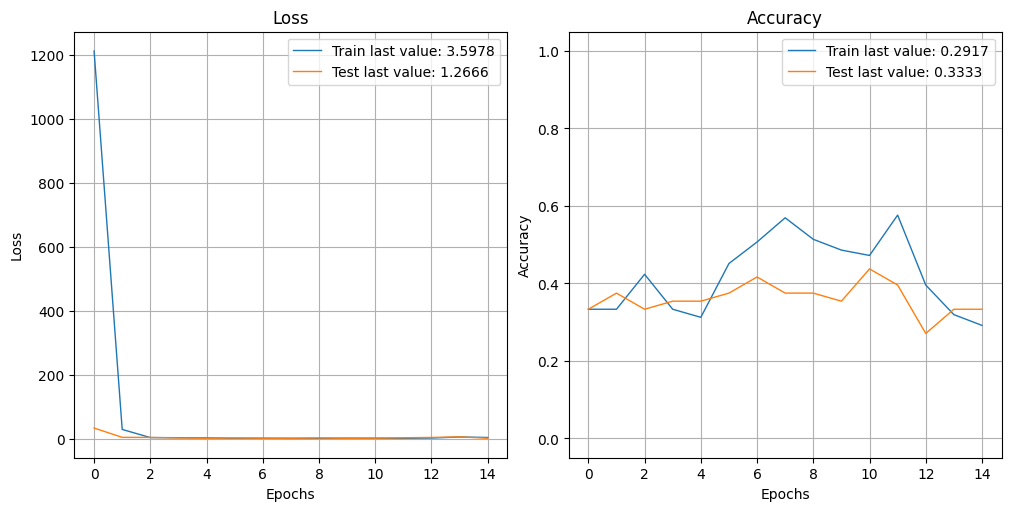

In [5]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history0)
plot_history(history0, path="model0.png")
plt.close()

2/2 [==============================] - 1s 64ms/step
Correspondance des clusters :  [0 0 0]
              precision    recall  f1-score   support

           0       0.33      1.00      0.50        16
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        16

    accuracy                           0.33        48
   macro avg       0.11      0.33      0.17        48
weighted avg       0.11      0.33      0.17        48



c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

<Axes: >

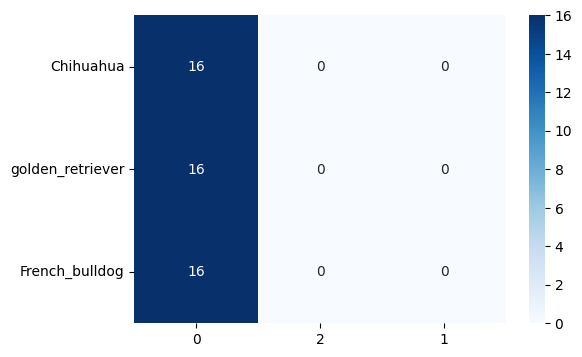

In [6]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model0.predict(X_val), axis=1)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

print(metrics.classification_report(y_val_num, y_val_pred_transform))

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in label_list])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Model custom v1 sans data augmentation

In [7]:
# Fonction create_custom_v1_model_fct
def create_custom_v1_model_fct(learning_rate=0.001, dropout_rate=0.5):
    import keras
    # Récupération modèle pré-entraîné
    model = keras.models.Sequential([
        # Première couche de convolution avec 128 filtres, kernel size de (11,11), et stride de (4,4)
        keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2,2)),

        # Deuxième couche de convolution avec 256 filtres, kernel size de (5,5), et stride de (1,1)
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3)),

        # Troisième couche de convolution avec 256 filtres, kernel size de (3,3), et stride de (1,1)
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),

        # Quatrième couche de convolution avec 256 filtres, kernel size de (1,1), et stride de (1,1)
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),

        keras.layers.MaxPool2D(pool_size=(2,2)),
        keras.layers.Flatten(), # Aplatir les données pour la transition vers les couches fully-connected

        # Couche fully-connected avec 1024 neurones et activation relu
        keras.layers.Dense(1024,activation='relu'),
        keras.layers.Dropout(dropout_rate), 
        keras.layers.Dense(categ,activation='softmax')  # Nombre de catégorie = 3
    ])

    # Création de l'instance de l'optimiseur RMSprop avec le taux d'apprentissage spécifié
    rmsprop_optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compilation du modèle avec la fonction de perte catégorielle_crossentropy et l'optimiseur RMSprop
    model.compile(loss="categorical_crossentropy", optimizer=rmsprop_optimizer, metrics=["accuracy"])

    # Résumé du modèle
    print(model.summary())

    return model

In [8]:
learning_rates = [0.001, 0.002, 0.005]
dropouts = [0.2, 0.4, 0.5]

#results = []
model_custom = "v1"

# Initialisation d'une liste pour stocker tous les historiques
all_histories = []

# Boucle pour chaque combinaison de taux d'apprentissage et de dropout
for lr in learning_rates:
    for dropout_rate in dropouts:

        # Ajout de la colonne "Data Augmentation" avec la valeur "sans"
        data_augmentation = "sans"

        print(f"Test du learning rate: {lr} et de dropout rate: {dropout_rate}")
        print()
        
        # Création du modèle avec les paramètres spécifiés
        model = create_custom_v1_model_fct(learning_rate=lr, dropout_rate=dropout_rate)

        # Création du callback
        model_save_path = f"./model/model_lr_{lr}_dropout_{dropout_rate}_best_weights.h5"
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        callbacks_list = [checkpoint, es]

        # Récupére le nombre de paramètres entraînables + non entraînables
        model_nb_params = model.count_params()

        # Entraînement du modèle
        history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                             callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
        
        # Ajout de l'historique à la liste
        all_histories.append((lr, dropout_rate, history))

        # Chargement des poids optimaux
        model.load_weights(model_save_path)

        loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=False)
        loss_t, accuracy_t = model.evaluate(X_test, y_test, verbose=False)

        print()
        print(f"Fin du test du learning rate: {lr} et de dropout rate: {dropout_rate}")
        print()
        print("-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

        results.append({
            'Model': model_custom,
            'Data Augmentation': data_augmentation,
            'Learning Rate': lr,
            'Dropout Rate': dropout_rate,
            'Validation Loss Optimal': loss_v,
            #'Test Loss Optimal': loss_t,
            'Validation Accuracy Optimal': accuracy_v,
            'Test Accuracy Optimal': accuracy_t,
            'Nombre de paramètres': model_nb_params
        })


Test du learning rate: 0.001 et de dropout rate: 0.2

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 54, 128)       46592     
                                                                 
 batch_normalization (Batch  (None, 54, 54, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 27, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                


c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 6.1464 - accuracy: 0.5347
Epoch 2: val_loss improved from 1465.57715 to 433.58585, saving model to ./model\model_lr_0.001_dropout_0.2_best_weights.h5
3/3 [==============================] - 5s 1s/step - loss: 6.1464 - accuracy: 0.5347 - val_loss: 433.5858 - val_accuracy: 0.3333
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 2.9806 - accuracy: 0.6181
Epoch 3: val_loss improved from 433.58585 to 94.77680, saving model to ./model\model_lr_0.001_dropout_0.2_best_weights.h5
3/3 [==============================] - 5s 1s/step - loss: 2.9806 - accuracy: 0.6181 - val_loss: 94.7768 - val_accuracy: 0.3542
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 2.1069 - accuracy: 0.5972
Epoch 4: val_loss did not improve from 94.77680
3/3 [==============================] - 5s 1s/step - loss: 2.1069 - accuracy: 0.5972 - val_loss: 103.4359 - val_accuracy: 0.3333
Epoch 5/50
3/3 [==============================] - ETA: 0s 

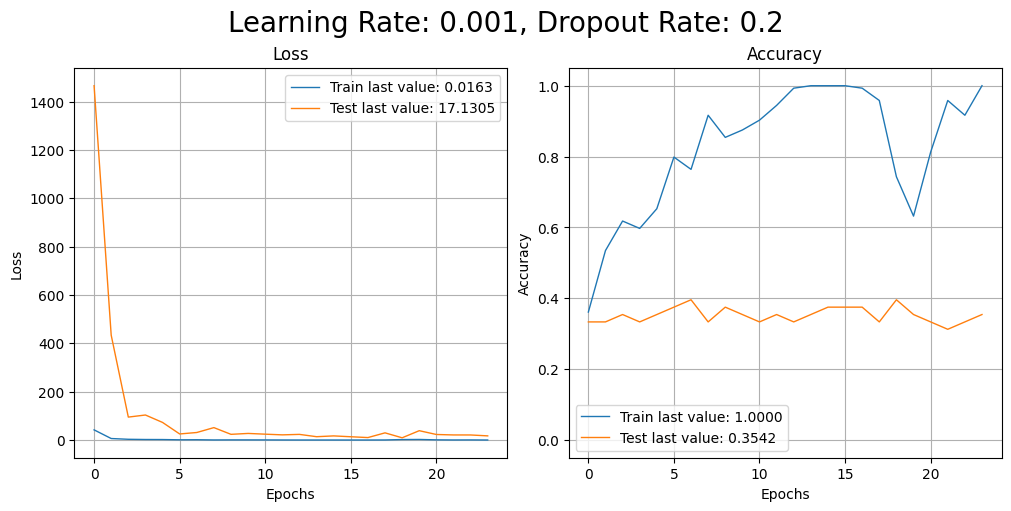

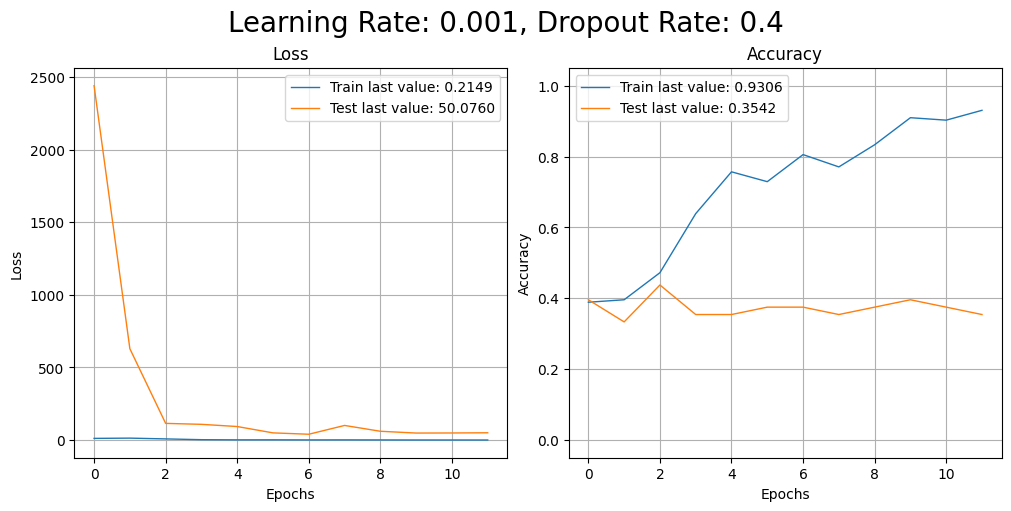

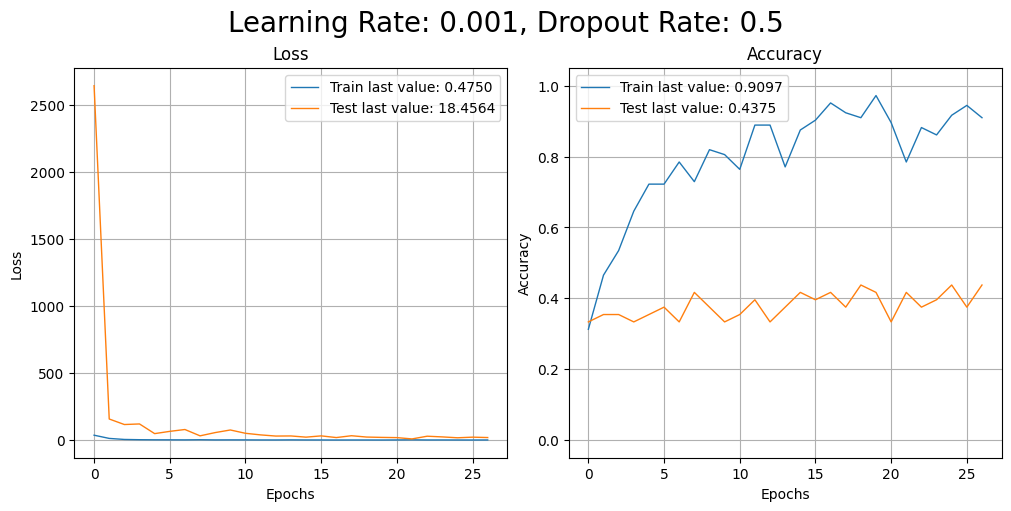

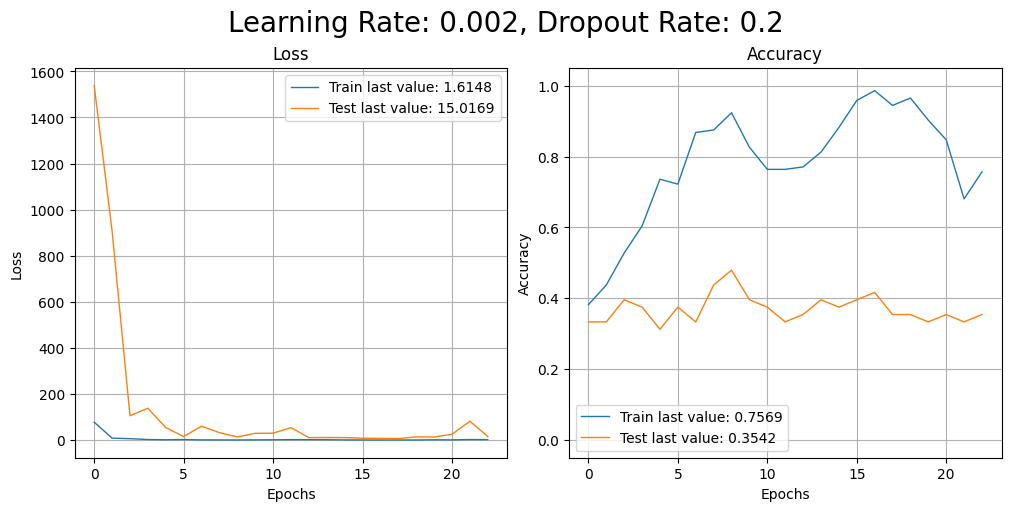

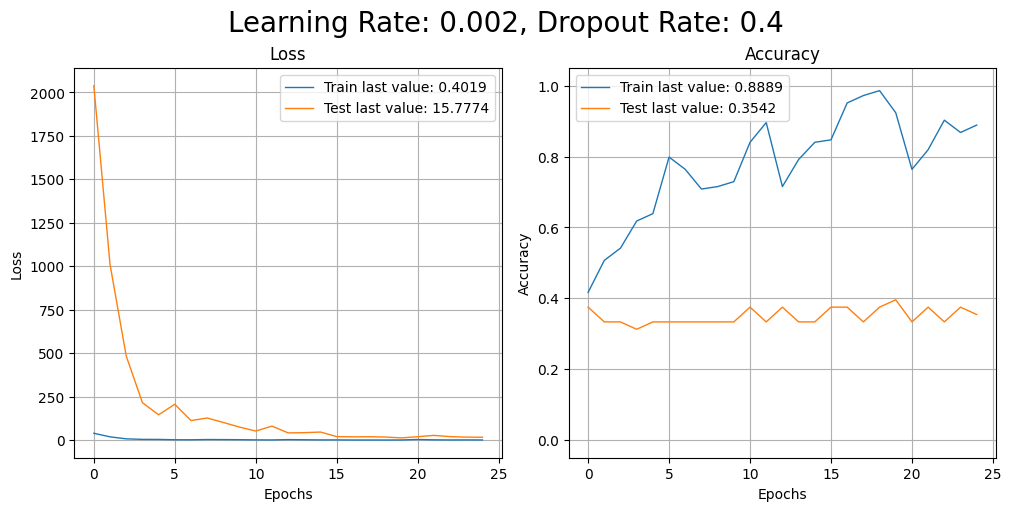

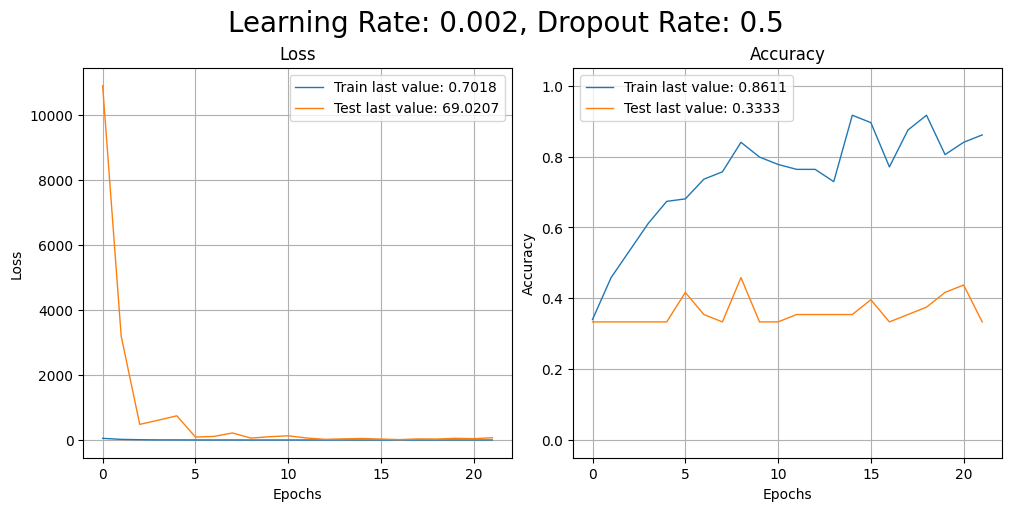

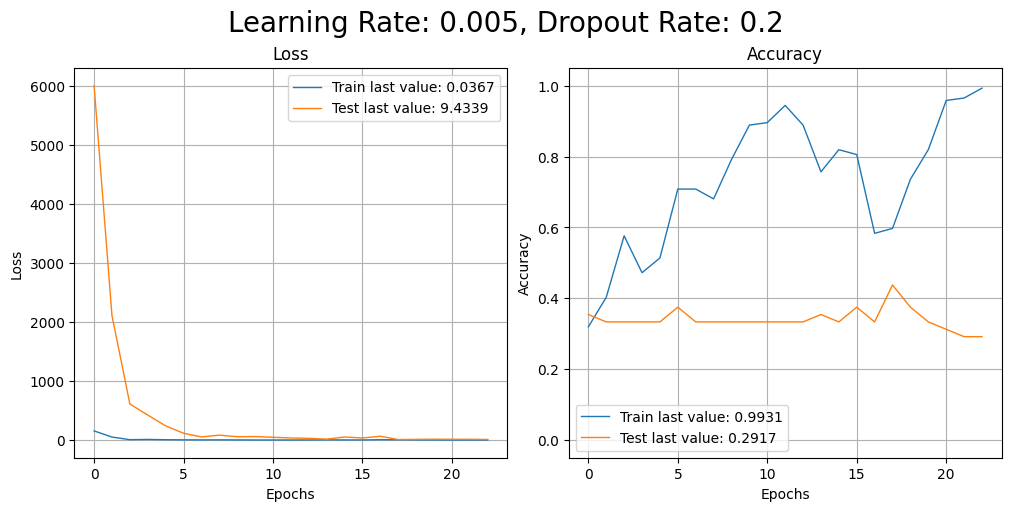

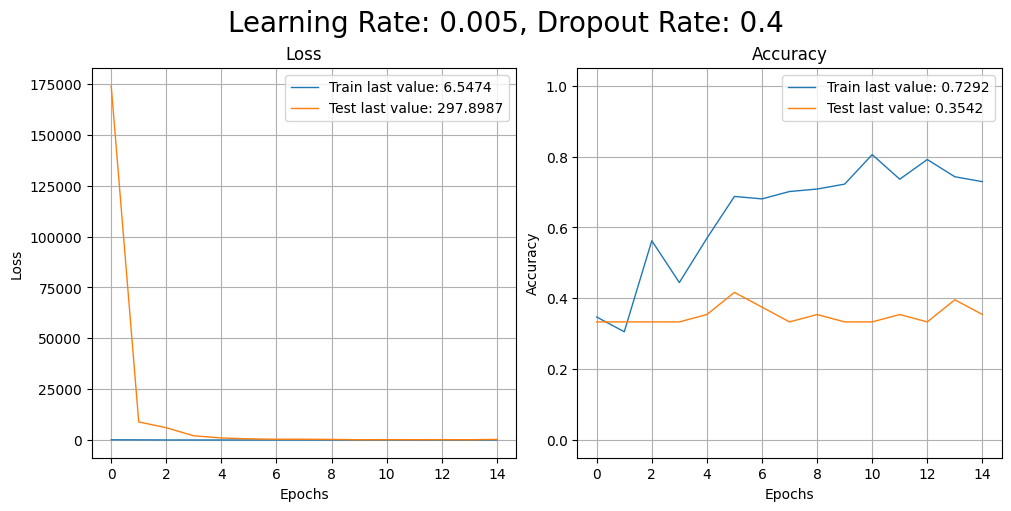

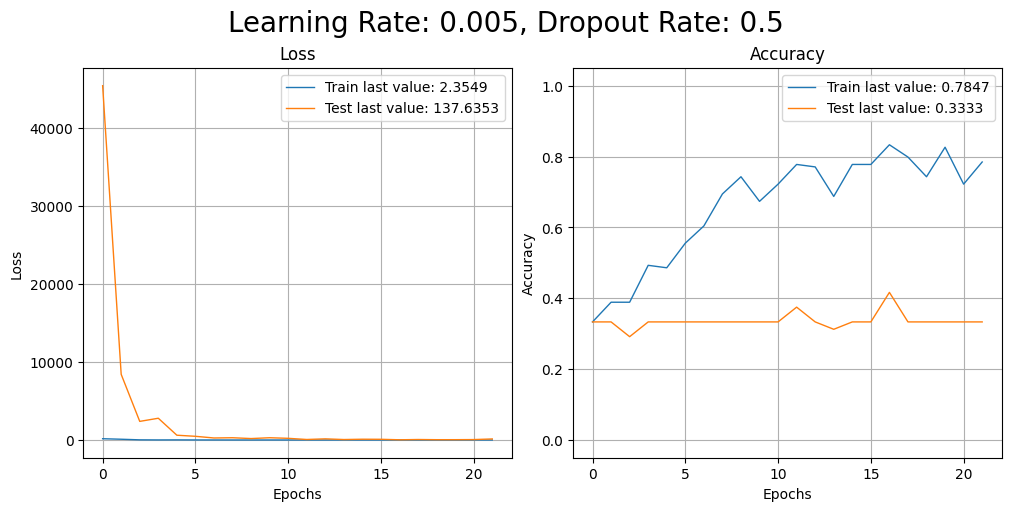

In [9]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

# Affichage de tous les historiques
for lr, dropout_rate, history in all_histories:
    title = f"Learning Rate: {lr}, Dropout Rate: {dropout_rate}"
    show_history(history, title=title)
    plot_history(history, path=f"model_history_lr_{lr}_dropout_{dropout_rate}.png", title=title)
    plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [5]:
# Emplacement des Images
path = "./Images3"
path_test = "./Images3_test"

batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset


dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 240 files belonging to 3 classes.


Using 180 files for training.
Found 240 files belonging to 3 classes.
Using 60 files for validation.
Found 60 files belonging to 3 classes.


In [6]:
def create_model_fct2(learning_rate=0.001, dropout_rate=0.5) :

    # Récupération modèle pré-entraîné
    import keras
    model = keras.models.Sequential([

        # Data augmentation
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)

        # Première couche de convolution avec 128 filtres, kernel size de (11,11), et stride de (4,4)
        keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2,2)),

        # Deuxième couche de convolution avec 256 filtres, kernel size de (5,5), et stride de (1,1)
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3)),

        # Troisième couche de convolution avec 256 filtres, kernel size de (3,3), et stride de (1,1)
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),

        # Quatrième couche de convolution avec 256 filtres, kernel size de (1,1), et stride de (1,1)
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),

        # Cinquième couche de convolution avec 256 filtres, kernel size de (1,1), et stride de (1,1)
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),

        keras.layers.MaxPool2D(pool_size=(2,2)),
        keras.layers.Flatten(), # Aplatir les données pour la transition vers les couches fully-connected

        # Première couche fully-connected avec 1024 neurones et activation relu
        keras.layers.Dense(1024,activation='relu'),
        keras.layers.Dropout(0.5), 

        # Deuxième couche fully-connected avec 1024 neurones et activation relu
        keras.layers.Dense(1024,activation='relu'),
        keras.layers.Dropout(dropout_rate), 
        keras.layers.Dense(categ,activation='softmax')  # Nombre de catégorie = 3
    ])

    # Création de l'instance de l'optimiseur RMSprop avec le taux d'apprentissage spécifié
    rmsprop_optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compilation du modèle avec la fonction de perte catégorielle_crossentropy et l'optimiseur RMSprop
    model.compile(loss="categorical_crossentropy", optimizer=rmsprop_optimizer, metrics=["accuracy"])

    print(model.summary())

    return model

In [14]:
# Initialisation d'une liste pour stocker tous les historiques
all_histories = []

# Boucle pour chaque combinaison de taux d'apprentissage et de dropout
for lr in learning_rates:
    for dropout_rate in dropouts:

        # Version du model
        model_custom = "v1"

        # Ajout de la colonne "Data Augmentation" avec la valeur "sans"
        data_augmentation = "avec"

        print(f"Test du learning rate: {lr} et de dropout rate: {dropout_rate}")
        print()
        
        # Création du modèle avec les paramètres spécifiés
        model = create_model_fct2(learning_rate=lr, dropout_rate=dropout_rate) #create_custom_v1_model_fct

        # Création du callback
        model_save_path = f"./model/model_data_augmentation_lr_{lr}_dropout_{dropout_rate}_best_weights.h5"
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        callbacks_list = [checkpoint, es]

        # Récupére le nombre de paramètres 
        model_nb_params = model.count_params()

        # Entraînement du modèle
        history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                             callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
        
        # Ajout de l'historique à la liste
        all_histories.append((lr, dropout_rate, history))

        # Chargement des poids optimaux
        model.load_weights(model_save_path)

        loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=False)
        loss_t, accuracy_t = model.evaluate(X_test, y_test, verbose=False)

        print()
        print(f"Fin du test du learning rate: {lr} et de dropout rate: {dropout_rate}")
        print()
        print("-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

        results.append({
            'Model': model_custom,
            'Data Augmentation': data_augmentation,
            'Learning Rate': lr,
            'Dropout Rate': dropout_rate,
            'Validation Loss Optimal': loss_v,
            'Validation Accuracy Optimal': accuracy_v,
            'Test Accuracy Optimal': accuracy_t,
            'Nombre de paramètres': model_nb_params
        })

# Création du DataFrame
results_df = pd.DataFrame(results)

Test du learning rate: 0.001 et de dropout rate: 0.2

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_10 (RandomFlip  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 random_rotation_10 (Random  (None, 224, 224, 3)       0         
 Rotation)                                                       
                                                                 
 random_zoom_10 (RandomZoom  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 conv2d_50 (Conv2D)          (None, 54, 54, 128)       46592     
                                                                 
 batch_normalization_50 (Ba  (None, 54, 54, 128)       512       

c:\Users\Wimok\Documents\Machine learning\Mes projets\P6\P6\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 13.9405 - accuracy: 0.3889
Epoch 2: val_loss improved from 2685.63184 to 39.08157, saving model to ./model\model_data_augmentation_lr_0.001_dropout_0.2_best_weights.h5
3/3 [==============================] - 5s 1s/step - loss: 13.9405 - accuracy: 0.3889 - val_loss: 39.0816 - val_accuracy: 0.3958
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 3.6339 - accuracy: 0.5278
Epoch 3: val_loss did not improve from 39.08157
3/3 [==============================] - 5s 1s/step - loss: 3.6339 - accuracy: 0.5278 - val_loss: 70.8967 - val_accuracy: 0.3333
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 2.0742 - accuracy: 0.5278
Epoch 4: val_loss did not improve from 39.08157
3/3 [==============================] - 6s 2s/step - loss: 2.0742 - accuracy: 0.5278 - val_loss: 100.4877 - val_accuracy: 0.3333
Epoch 5/50
3/3 [==============================] - ETA: 0s - loss: 1.3675 - accuracy: 0.5694
Epoch 5: val_loss did 

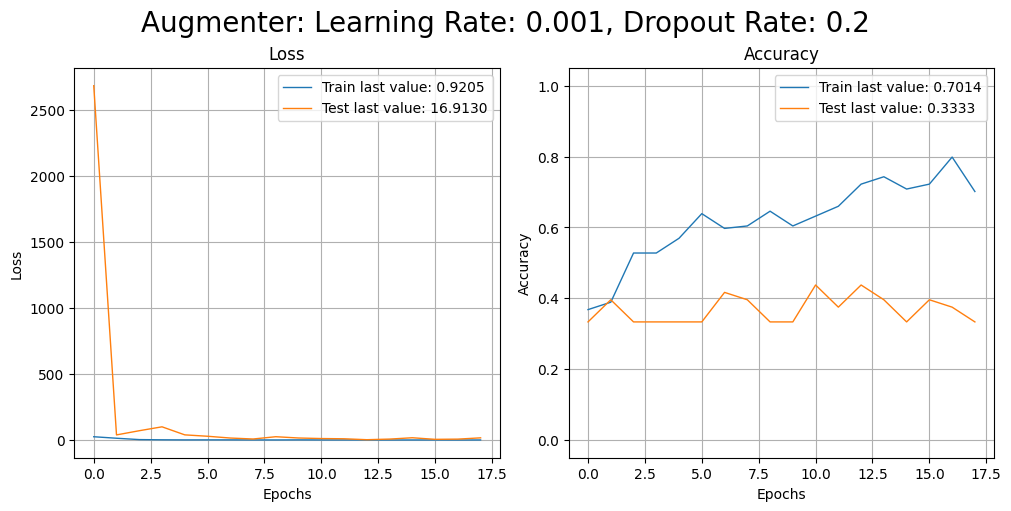

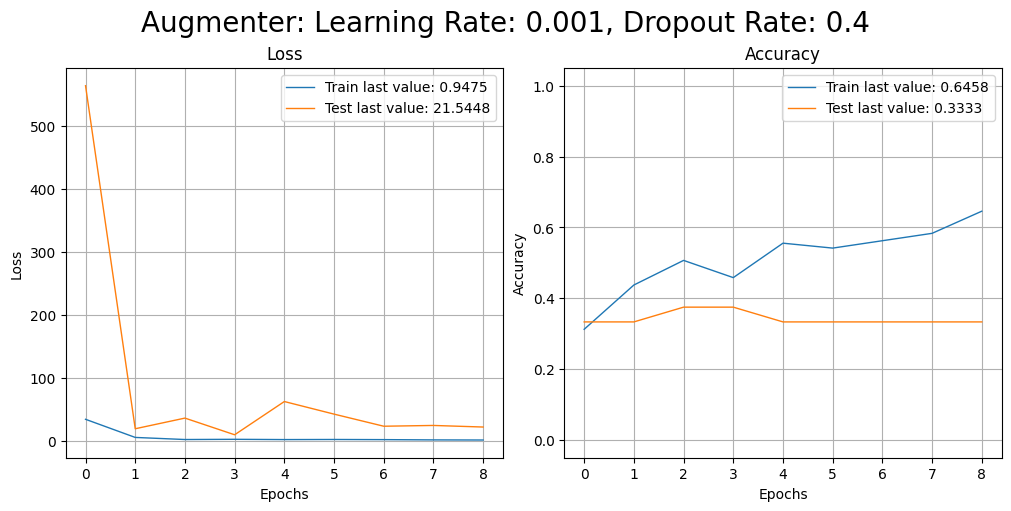

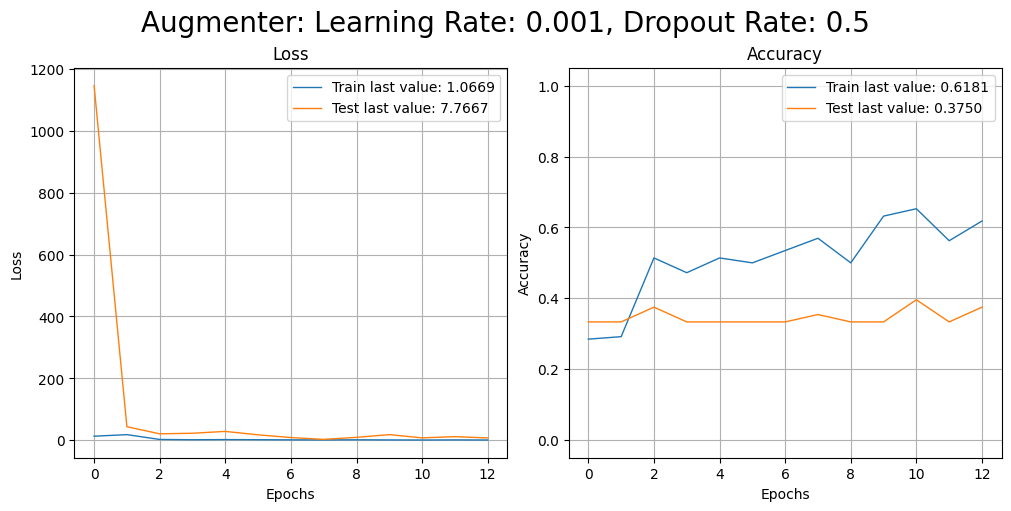

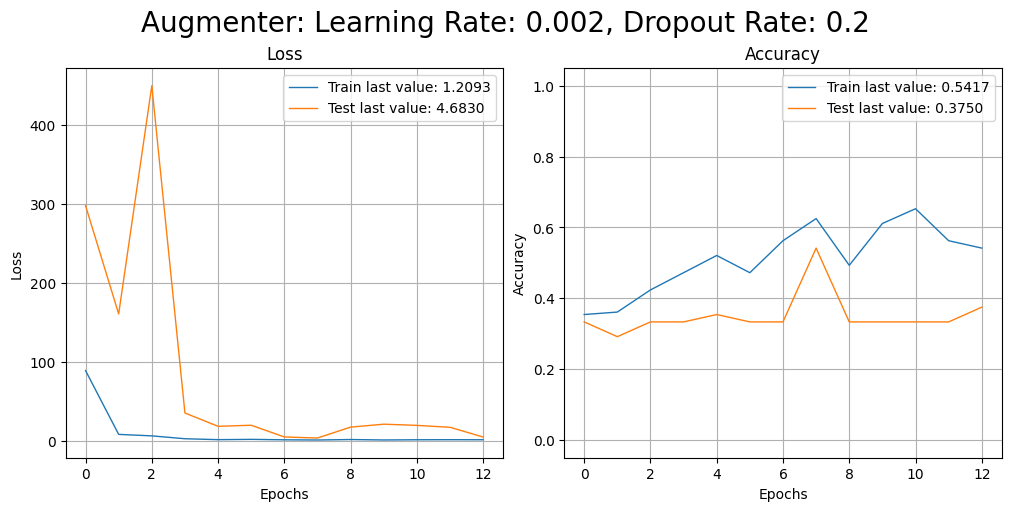

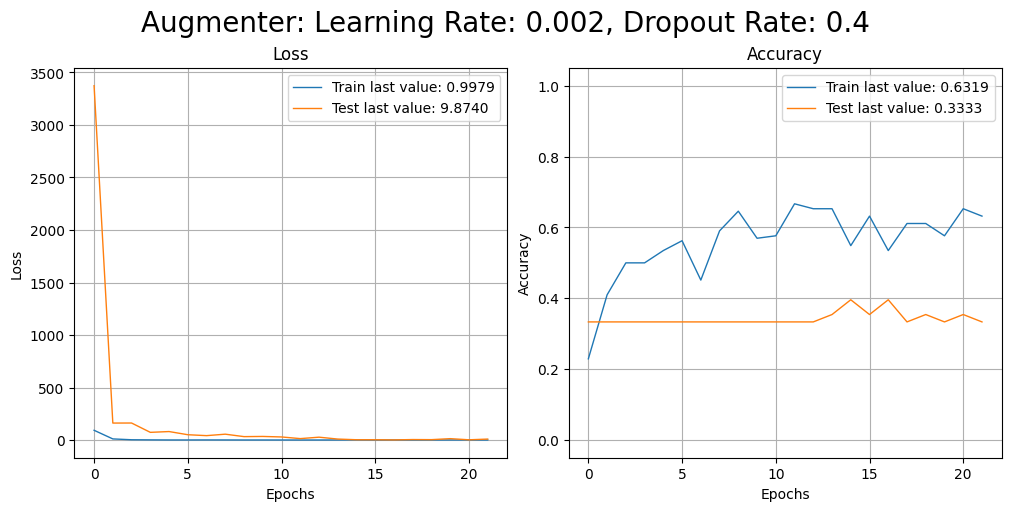

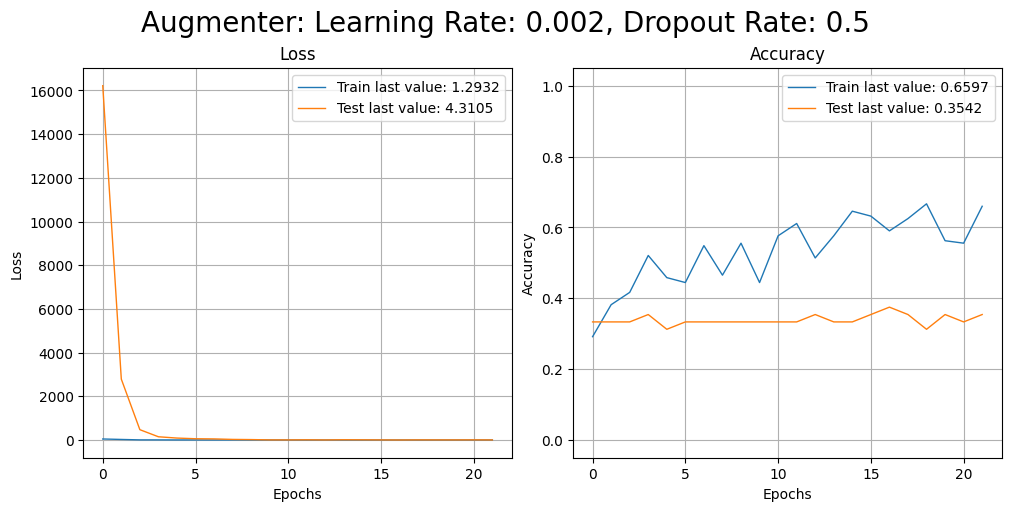

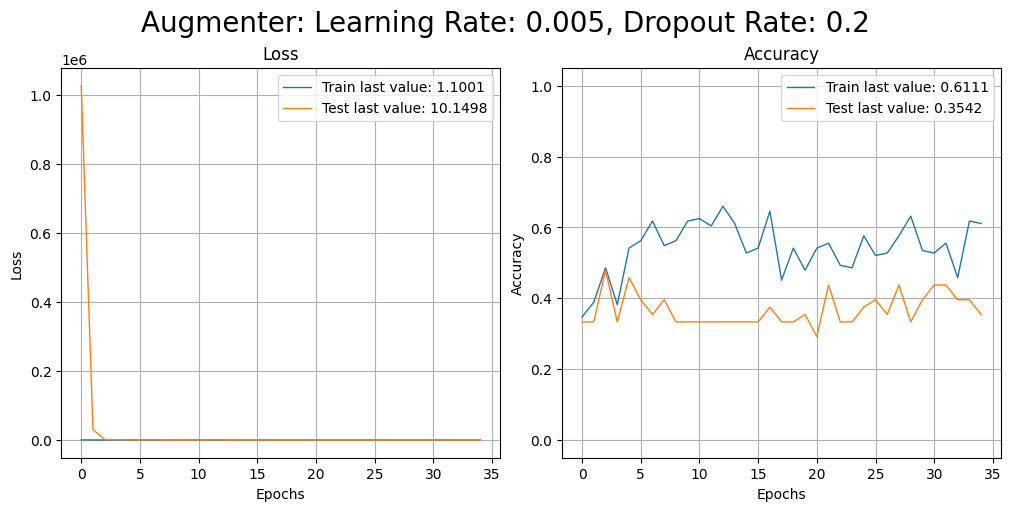

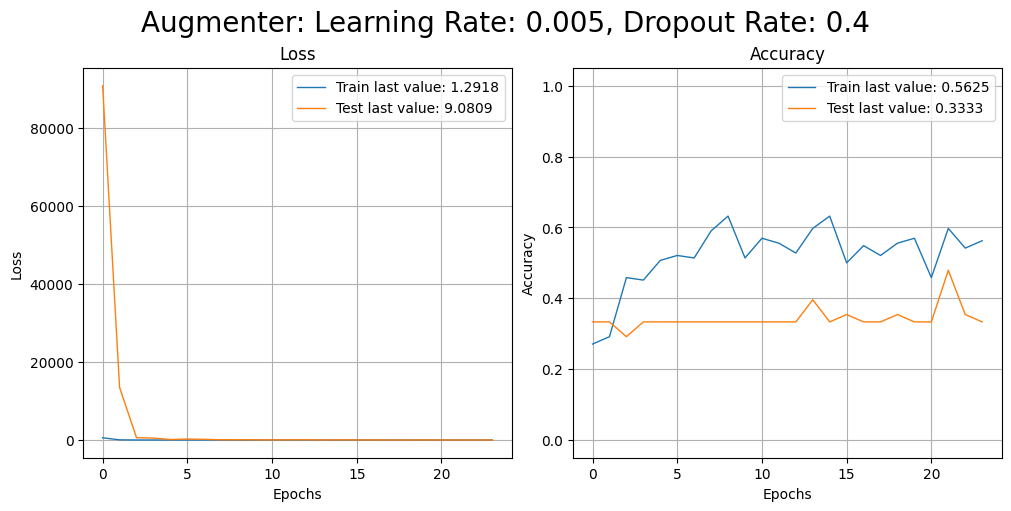

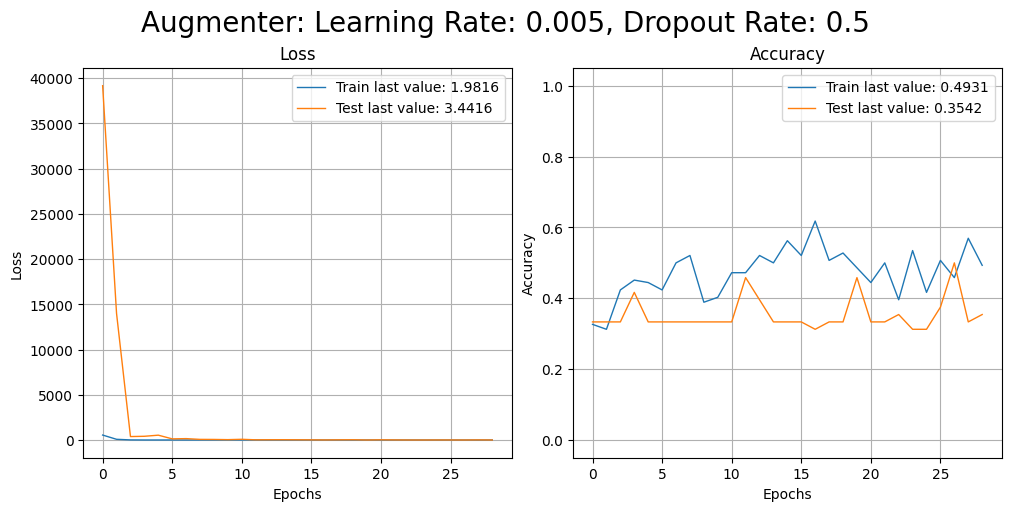

In [15]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

# Affichage de tous les historiques
for lr, dropout_rate, history in all_histories:
    title = f"Augmenter: Learning Rate: {lr}, Dropout Rate: {dropout_rate}"
    show_history(history, title=title)
    plot_history(history, path=f"model_history_augmenter_lr_{lr}_dropout_{dropout_rate}.png", title=title)
    plt.close()

# Tableau des resultats

In [16]:
results_df

,Model,Data Augmentation,Validation Loss Optimal,Validation Accuracy Optimal,Test Accuracy Optimal,Nombre de paramètres,Learning Rate,Dropout Rate
0,V0,sans,1.266567,0.333333,0.354167,1442947,NaN,NaN
1,v1,sans,9.182384,0.395833,0.291667,5723907,0.001,0.2
2,v1,sans,39.916843,0.375000,0.437500,5723907,0.001,0.4
3,v1,sans,8.300183,0.416667,0.479167,5723907,0.001,0.5
4,v1,sans,6.242844,0.354167,0.354167,5723907,0.002,0.2
5,v1,sans,12.342187,0.395833,0.333333,5723907,0.002,0.4
6,v1,sans,12.159389,0.333333,0.437500,5723907,0.002,0.5
7,v1,sans,7.499078,0.437500,0.395833,5723907,0.005,0.2
8,v1,sans,138.285706,0.333333,0.354167,5723907,0.005,0.4
9,v1,sans,30.117920,0.416667,0.312500,5723907,0.005,0.5


In [17]:
# Résultat par ordre croissant sur Test Accuracy Optimal
results_df.sort_values(by='Test Accuracy Optimal')

,Model,Data Augmentation,Validation Loss Optimal,Validation Accuracy Optimal,Test Accuracy Optimal,Nombre de paramètres,Learning Rate,Dropout Rate
1,v1,sans,9.182384,0.395833,0.291667,5723907,0.001,0.2
9,v1,sans,30.117920,0.416667,0.312500,5723907,0.005,0.5
17,v1,avec,2.159613,0.395833,0.333333,6840323,0.005,0.4
5,v1,sans,12.342187,0.395833,0.333333,5723907,0.002,0.4
13,v1,avec,2.728584,0.375000,0.354167,6840323,0.002,0.2
8,v1,sans,138.285706,0.333333,0.354167,5723907,0.005,0.4
0,V0,sans,1.266567,0.333333,0.354167,1442947,NaN,NaN
4,v1,sans,6.242844,0.354167,0.354167,5723907,0.002,0.2
15,v1,avec,3.863509,0.458333,0.375000,6840323,0.002,0.5
7,v1,sans,7.499078,0.437500,0.395833,5723907,0.005,0.2


In [18]:
# Résultat par ordre croissant sur Validation Accuracy Optimal
results_df.sort_values(by='Validation Accuracy Optimal')

,Model,Data Augmentation,Validation Loss Optimal,Validation Accuracy Optimal,Test Accuracy Optimal,Nombre de paramètres,Learning Rate,Dropout Rate
18,v1,avec,2.054702,0.291667,0.437500,6840323,0.005,0.5
8,v1,sans,138.285706,0.333333,0.354167,5723907,0.005,0.4
6,v1,sans,12.159389,0.333333,0.437500,5723907,0.002,0.5
0,V0,sans,1.266567,0.333333,0.354167,1442947,NaN,NaN
4,v1,sans,6.242844,0.354167,0.354167,5723907,0.002,0.2
14,v1,avec,14.865101,0.354167,0.395833,6840323,0.002,0.4
2,v1,sans,39.916843,0.375000,0.437500,5723907,0.001,0.4
10,v1,avec,2.565145,0.375000,0.395833,6840323,0.001,0.2
13,v1,avec,2.728584,0.375000,0.354167,6840323,0.002,0.2
5,v1,sans,12.342187,0.395833,0.333333,5723907,0.002,0.4
